# Import required libraries

In [40]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import cross_validate,train_test_split,cross_val_score,RandomizedSearchCV,learning_curve
from sklearn.ensemble import RandomForestClassifier, StackingClassifier,AdaBoostClassifier,VotingClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from hyperopt import fmin, hp, tpe, Trials,STATUS_OK
import pickle
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score,f1_score,recall_score,precision_score,classification_report,make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler,SMOTE
from sklearn.svm import SVC
import time
import seaborn as sns
from collections import Counter
import mediapipe as mp
import string

# Load the required training and testing dataframes

In [41]:
f=open('final_training_df.pickle','rb')
train_df=pickle.load(f)
f.close()

In [42]:
f=open('pin_test_df.pickle','rb')
test_df=pickle.load(f)
f.close()

# Featuring engineering to create one more feature.
### Ratio of hand based on the maximum coordinate point in x and y

In [45]:
for index, row in train_df.iterrows():
    x_list=[]
    y_list=[]
    """
    For each row, consist a hand sign with 21 pairs of hand coordinate (x1,y1,x2,y2,....,x21,y21)
    Extract all x and y out as separate list
    Get the max and min of both x and y
    Use max x minus min x and max y minus min y.
    Then divide it and get the ratio for each hand sign.
    Idea is the same hand sign, the ratio should be more or less the same.
    The feature is to make the model more robush to hand with the similar sign.
    Then add this ratio of each hand sign to a new column.
    One picture is one row given a handsign.
    """
    for i in range(42):
        if i % 2 == 0:
            x_list.append(row[i])
            # print(i)
            # max_x = np.max(row[i])
            # min_x = np.min(row[i])
        else:
            # max_y = np.max(row[i])
            # min_y = np.min(row[i])
            y_list.append(row[i])
    max_x = np.max(x_list)
    min_x = np.min(x_list)  
    max_y = np.max(y_list)
    min_y = np.min(y_list) 
    
    ratio = (max_x - min_x) / (max_y - min_y)
    train_df.loc[index, '42'] = ratio

# Applying same method for test dataframe

In [46]:
for index, row in test_df.iterrows():
    x_list=[]
    y_list=[]

    for i in range(42):
        if i % 2 == 0:
            x_list.append(row[i])
            # print(i)
            # max_x = np.max(row[i])
            # min_x = np.min(row[i])
        else:
            # max_y = np.max(row[i])
            # min_y = np.min(row[i])
            y_list.append(row[i])
    max_x = np.max(x_list)
    min_x = np.min(x_list)  
    max_y = np.max(y_list)
    min_y = np.min(y_list) 
    
    ratio = (max_x - min_x) / (max_y - min_y)
    test_df.loc[index, '42'] = ratio

# Check the class balancing

<AxesSubplot:xlabel='label', ylabel='Count'>

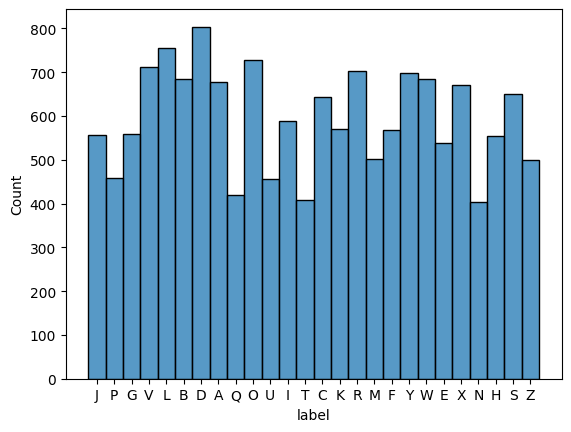

In [48]:

sns.histplot(train_df['label'])

# Class inbalance, futher processing is needed later

# Train test split based on train and test dataframe

In [49]:
X_train = train_df.drop('label', axis=1)
y_train = train_df['label']
X_test = test_df.drop('label', axis=1)
y_test = test_df['label']


# Perform oversampler technique to balance the class

In [50]:

os = RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)


/home/jwshee/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


# Label encoding the target of train and test. We have total 26 letters of alphabet. After the encoding, we have value from 0-25. 0 refering to A while 25 refering to Z

In [51]:
encoder=LabelEncoder()
y_train_res_encoded=encoder.fit_transform(y_train_res)
y_test_encoded=encoder.transform(y_test)

# Mahcine learning start with three different algorithms

In [52]:
model_lgb=LGBMClassifier(boosting_type='dart', num_leaves=20, max_depth=6, learning_rate=0.3, n_estimators=100, min_child_samples=400, subsample=0.5,
                         colsample_bytree=1.0, reg_alpha=0.6, reg_lambda=0.8, n_jobs=-1,objective='multiclass')
model_xg=XGBClassifier()
model_forest=RandomForestClassifier(oob_score=True)
# model_svc=SVC(C=0.1,gamma=10,probability=True)
# model_k=KNeighborsClassifier(n_neighbors=17,weights='uniform',algorithm='ball_tree')

# Created a few dictionary to store the details
### The trained model also being store in a dictionary as value. So later, different trained model can be direcly called out from the dictionary given a key. In this method, we do not loss all the details and do not need to keep calling different model with different name. Just call the dictionary will do.

In [53]:
models=[model_lgb,model_xg,model_forest]
models_name=['model_lgb','model_xg','model_forest']
train_model = {}
training_times = {}
prediction_times = {}
accuracy = {}
f1 = {}
recall = {}
precision = {}
for index,model in zip(models_name,models):
    
    start_train=time.time()
    model.fit(X_train_res,y_train_res_encoded)
    training_time=time.time()-start_train
    print(f"{index} training time: {training_time} seconds")

    start_predict=time.time()
    y_pred=model.predict(X_test)
    prediction_time=time.time()-start_predict
    print(f"{index} prediction time: {prediction_time} seconds")
    
    score_acc=accuracy_score(y_test_encoded,y_pred)
    score_f1=f1_score(y_test_encoded,y_pred,average='micro')
    score_rec=recall_score(y_test_encoded,y_pred,average='micro')
    score_pre=precision_score(y_test_encoded,y_pred,average='micro')
    
    
    train_model[index]=model
    training_times[index]=training_time
    prediction_times[index]=prediction_time
    accuracy[index]=score_acc
    f1[index] =score_f1
    recall[index]= score_rec
    precision [index]=score_pre

model_lgb training time: 2.750257968902588 seconds
model_lgb prediction time: 0.011474132537841797 seconds
model_xg training time: 17.37993884086609 seconds
model_xg prediction time: 0.005774021148681641 seconds


/home/jwshee/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


model_forest training time: 8.107223749160767 seconds
model_forest prediction time: 0.01540994644165039 seconds


/home/jwshee/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


# Create a dataframe to overview the performance of different model

In [54]:
rows = list(accuracy.keys())
cols = ['accuracy', 'recall', 'precision', 'training_time', 'prediction_time']

acc = [accuracy[i] for i in rows]
rec = [recall[i] for i in rows]
pre = [precision[i] for i in rows]
train_time = [training_times[i] for i in rows]
pred_time = [prediction_times[i] for i in rows]

check = pd.DataFrame({cols[0]:acc, cols[1]: rec,
                      cols[2]: pre, cols[3]: train_time,
                      cols[4]: pred_time}, index=rows)
check

,accuracy,recall,precision,training_time,prediction_time
model_lgb,0.434118,0.434118,0.434118,2.750258,0.011474
model_xg,0.396471,0.396471,0.396471,17.379939,0.005774
model_forest,0.369412,0.369412,0.369412,8.107224,0.015410


# Call all the trained model to do prediction directly via the trained dictionary. Then we store all the predicted result given a model in the dictionary as well. Given the key as the name of model, the predicted result from the model will be displayed.

In [38]:
prediction={}
for i in train_model:    
    y_pred=train_model[i].predict(X_test)
    prediction[i]=y_pred

/home/jwshee/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


# Saved the selected xgb model

In [ ]:
# # Save the trained model
# model_xg.save_model('xgb_model_2906.xgb')

# Check the classfication report for the performance of different model

In [39]:
print('lgb', classification_report(y_test_encoded,prediction['model_lgb']))
print('xg', classification_report(y_test_encoded,prediction['model_xg']))
print('forest', classification_report(y_test_encoded,prediction['model_forest']))
# print('SVC', classification_report(y_test_encoded,prediction['model_svc']))
# print('kneighbour', classification_report(y_test_encoded,prediction['model_k']))

lgb               precision    recall  f1-score   support

           0       0.97      0.99      0.98        68
           1       1.00      0.99      0.99        69
           2       1.00      1.00      1.00        64
           3       0.99      1.00      0.99        80
           4       1.00      1.00      1.00        54
           5       0.98      1.00      0.99        57
           6       1.00      1.00      1.00        56
           7       1.00      1.00      1.00        55
           8       0.98      0.92      0.95        59
           9       0.96      0.93      0.95        56
          10       1.00      0.98      0.99        57
          11       0.97      0.99      0.98        76
          12       1.00      0.98      0.99        50
          13       1.00      1.00      1.00        40
          14       0.97      0.97      0.97        73
          15       0.98      1.00      0.99        46
          16       1.00      0.95      0.98        42
          17       1.00

# Plot the confusion matrix for the xgb model

In [ ]:
plt.figure(figsize=(16,9))
alphabet_labels = list(string.ascii_uppercase)
sns.heatmap(confusion_matrix(y_test_encoded,prediction['model_xg']), annot=True, xticklabels=alphabet_labels, yticklabels=alphabet_labels)
plt.show();

# Check how the encoder label the target

In [ ]:
for idx, i in enumerate(encoder.__dict__['classes_']):
    print(f'{idx} -> {i}')

# Trying to use hyperopt to fine tune different model. Then finally save the best model. Can ignore everything from here onward

In [ ]:
def increase_precision(params):   
    model_lgb=LGBMClassifier(boosting_type='dart',
                             num_leaves=int(params['num_leaves']),
                             max_depth=int(params['max_depth']),
                             n_estimators=int(params['n_estimators']),
                             objective='multiclass', n_jobs=-1,
                             learning_rate=params['learning_rate'],
                             reg_alpha=params['reg_alpha'],
                             reg_lambda=params['reg_lambda'],
                             min_child_samples=int(params['min_child_samples']))
    
    
    
    model_lgb.fit(X_train_res,y_train_res_encoded)
    y_pred=model_lgb.predict(X_test)
    accuracy =accuracy_score(y_test_encoded,y_pred)
    score_pre=precision_score(y_test_encoded,y_pred,average='micro')

    return {'loss': -score_pre, 'status': STATUS_OK}
    
    


space = {
    "n_estimators": hp.quniform("n_estimators",50,250,5),
    "max_depth": hp.quniform("max_depth", 10, 250 ,5),
    "num_leaves": hp.quniform("num_leaves",20,100,5),
    'min_child_samples':hp.quniform('min_child_samples',20,300,10),
    'reg_alpha':hp.uniform('reg_alpha',0,5),
    'reg_lambda':hp.uniform('reg_lambda',0,5),
    "learning_rate": hp.uniform("learning_rate",0.01,0.1)
}
trials=Trials()
best = fmin(fn=increase_precision,
    space = space, 
    algo=tpe.suggest, 
    max_evals=50, 
    trials=trials
)

print("Best Hyperparameters:",best)


In [ ]:
scorer=make_scorer(precision_score)
param_dist = {
    'boosting_type': ['dart'],
    'num_leaves': np.arange(20, 200,10),
    'max_depth': np.arange(5, 50,1),
    'learning_rate': [0.01,0.05,0.1,0.3],
    'subsample': np.arange(0.4, 0.6,0.1),
    'colsample_bytree': np.arange(0.4, 0.6,0.1),
    'reg_alpha': np.arange(0, 1,0.2),
    'reg_lambda': np.arange(0, 1,0.2),
    'min_child_samples': [100,200,300,400,500]
}
random_search = RandomizedSearchCV(model_lgb, param_dist, n_iter=10, cv=5,n_jobs=-1,scoring=scorer)
random_search.fit(X_train_res,y_train_res_encoded)
pd.DataFrame(random_search.cv_results_).sort_values(['mean_test_score'])

In [ ]:
# random_search.best_estimator_

In [ ]:
# param_dist = {'n_neighbors': np.arange(1, 20,2),
#               'weights': ['uniform', 'distance'],
#               'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#               'p': [1, 2]}
# random_search = RandomizedSearchCV(model_k, param_dist, n_iter=50, cv=5,n_jobs=-1)
# random_search.fit(X_train_res,y_train_res_encoded)
# pd.DataFrame(random_search.cv_results_).sort_values(['mean_test_score'])

In [ ]:
# random_search.best_estimator_

In [ ]:
# param_dist = {
#     'max_depth': np.arange(3, 10,1),
#     'learning_rate': [0.01,0.1,0.2, 0.3],
#     'n_estimators': np.arange(100, 1000,25),
#     'subsample': np.arange(0.4, 0.6,0.1),
#     'colsample_bytree': np.arange(0.4,0.6, 0.1),
#     'gamma': np.arange(0, 5,1),
#     'reg_alpha': np.arange(0, 1,0.1),
#     'reg_lambda': np.arange(0, 1,0.1),
# }
# random_search = RandomizedSearchCV(model_xg, param_dist, n_iter=10, cv=5,n_jobs=-1)
# random_search.fit(X_train_res,y_train_res_encoded)
# pd.DataFrame(random_search.cv_results_).sort_values(['mean_test_score'])

In [ ]:
# param_grid = {'C': [0.1, 1, 10],
#               'kernel': ['linear', 'rbf'],
#               'gamma': [0.1, 1, 10]}

# # Perform grid search with cross-validation
# search = RandomizedSearchCV(model_svc, param_grid, cv=5,n_jobs=-1, n_iter=10,scoring='precision')
# search.fit(X_train_res,y_train_res_encoded)

# # Get the best hyperparameters and model
# best_params = search.best_params_
# best_model = search.best_estimator_

# pd.DataFrame(search.cv_results_).sort_values(['mean_test_score'])

In [ ]:
# param_dist = {
#     'n_estimators': np.arange(50, 500,10),
#     'max_depth': np.arange(5, 50,5),
#     'min_samples_split': np.arange(2, 20,2),
#     'min_samples_leaf': np.arange(1, 5,1),
#     'max_features': ['auto', 'sqrt'],
#     'bootstrap': [True, False],
#     'criterion': ['gini', 'entropy']
# }
# search = RandomizedSearchCV(model_forest, param_grid, cv=5,n_jobs=-1, n_iter=10)
# search.fit(X_train_res,y_train_res_encoded)
# pd.DataFrame(search.cv_results_).sort_values(['mean_test_score'])